# Medical X-Ray Data Processing

This notebook explores the VinBigData Chest X-ray dataset and prepares it for training a YOLOv8 model. We'll analyze the annotation structure, examine the distribution of different medical findings, and prepare the data for the YOLO format.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import yaml
import pydicom
from pathlib import Path
import random

plt.style.use('fivethirtyeight')
sns.set_context('notebook')

## Loading Annotations

The VinBigData Chest X-ray dataset provides annotations in CSV format with bounding boxes for 14 different thoracic findings:
- 0 - Aortic enlargement
- 1 - Atelectasis
- 2 - Calcification
- 3 - Cardiomegaly
- 4 - Consolidation
- 5 - ILD
- 6 - Infiltration
- 7 - Lung Opacity
- 8 - Nodule/Mass
- 9 - Other lesion
- 10 - Pleural effusion
- 11 - Pleural thickening
- 12 - Pneumothorax
- 13 - Pulmonary fibrosis


In [2]:
data_path = Path('../data/raw')
train_df = pd.read_csv(data_path / 'train.csv')
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN


## Dataset Structure Analysis

Let's examine the structure and size of the dataset to understand what we're working with.

In [3]:
print(f"Dataset shape: {train_df.shape}")
print(f"Number of unique images: {train_df['image_id'].nunique()}")

Dataset shape: (67914, 8)
Number of unique images: 15000


## Class Distribution

The dataset includes annotations for 14 different thoracic abnormalities, plus a "No finding" class. Understanding the distribution helps us identify potential class imbalance.

In [4]:
class_names = {
    0: 'Aortic enlargement',
    1: 'Atelectasis',
    2: 'Calcification',
    3: 'Cardiomegaly',
    4: 'Consolidation',
    5: 'ILD',
    6: 'Infiltration',
    7: 'Lung Opacity',
    8: 'Nodule/Mass',
    9: 'Other lesion',
    10: 'Pleural effusion',
    11: 'Pleural thickening',
    12: 'Pneumothorax',
    13: 'Pulmonary fibrosis',
    14: 'No finding'
}

class_distribution = train_df['class_id'].value_counts().sort_index()
named_distribution = pd.Series({class_names[k]: v for k, v in class_distribution.items()}, 
                              name='count')
named_distribution

Aortic enlargement     7162
Atelectasis             279
Calcification           960
Cardiomegaly           5427
Consolidation           556
ILD                    1000
Infiltration           1247
Lung Opacity           2483
Nodule/Mass            2580
Other lesion           2203
Pleural effusion       2476
Pleural thickening     4842
Pneumothorax            226
Pulmonary fibrosis     4655
No finding            31818
Name: count, dtype: int64

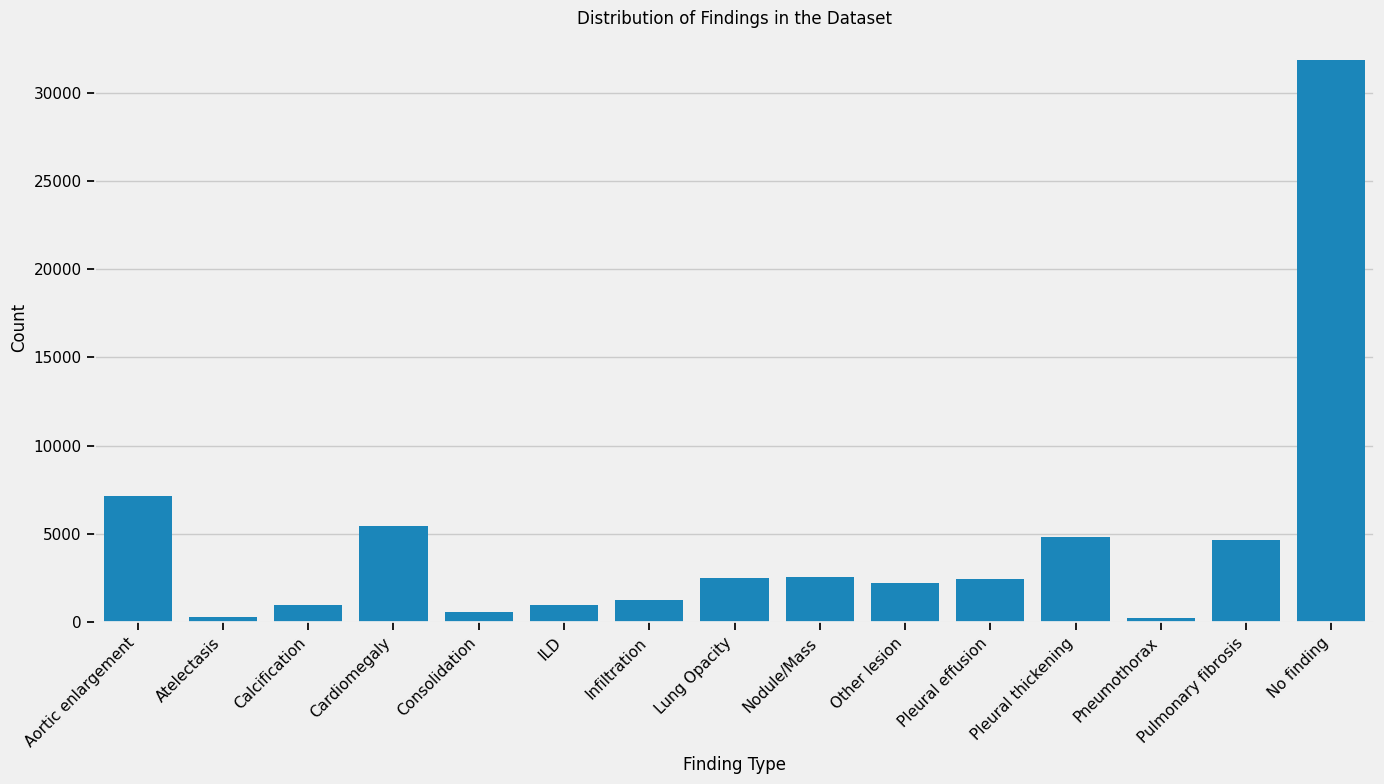

In [5]:
plt.figure(figsize=(14, 8))
ax = sns.barplot(x=named_distribution.index, y=named_distribution.values)
ax.set_xticks(ax.get_xticks())  
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Distribution of Findings in the Dataset')
plt.ylabel('Count')
plt.xlabel('Finding Type')
plt.tight_layout()
plt.show()

### Class Distribution Analysis

The dataset exhibits extreme class imbalance with "No finding" dominating (48% of annotations). Critical conditions like Pneumothorax (226) and Atelectasis (279) are severely underrepresented. This requires:
- Specialized loss functions
- Targeted data augmentation
- Clinically-calibrated detection thresholds

#### Handling the `No finding` Class:

For object detection with YOLOv8:
- **Exclude this class** - Object detection typically focuses on identifying present abnormalities
- YOLOv8 naturally handles absence of detections without requiring explicit "normal" labels
- Including "No finding" would create empty bounding boxes, contradicting the detection paradigm

We'll proceed without the "No finding" class in our YOLO implementation, treating the absence of detections as the normal state, which is the standard approach in medical object detection.

In [6]:
finding_df = train_df[train_df['class_id'] != 14].copy()


finding_distribution = finding_df['class_id'].value_counts().sort_index()
named_finding_distribution = pd.Series({class_names[k]: v for k, v in finding_distribution.items()}, 
                                      name='count')

named_finding_distribution

Aortic enlargement    7162
Atelectasis            279
Calcification          960
Cardiomegaly          5427
Consolidation          556
ILD                   1000
Infiltration          1247
Lung Opacity          2483
Nodule/Mass           2580
Other lesion          2203
Pleural effusion      2476
Pleural thickening    4842
Pneumothorax           226
Pulmonary fibrosis    4655
Name: count, dtype: int64

## Bounding Box Analysis

Understanding the characteristics of bounding boxes helps us optimize our detection model. Let's examine the size, aspect ratio, and position of annotations across different findings.

In [7]:
finding_df['width'] = finding_df['x_max'] - finding_df['x_min']
finding_df['height'] = finding_df['y_max'] - finding_df['y_min']
finding_df['area'] = finding_df['width'] * finding_df['height']
finding_df['aspect_ratio'] = finding_df['width'] / finding_df['height']

### Bounding Box Size

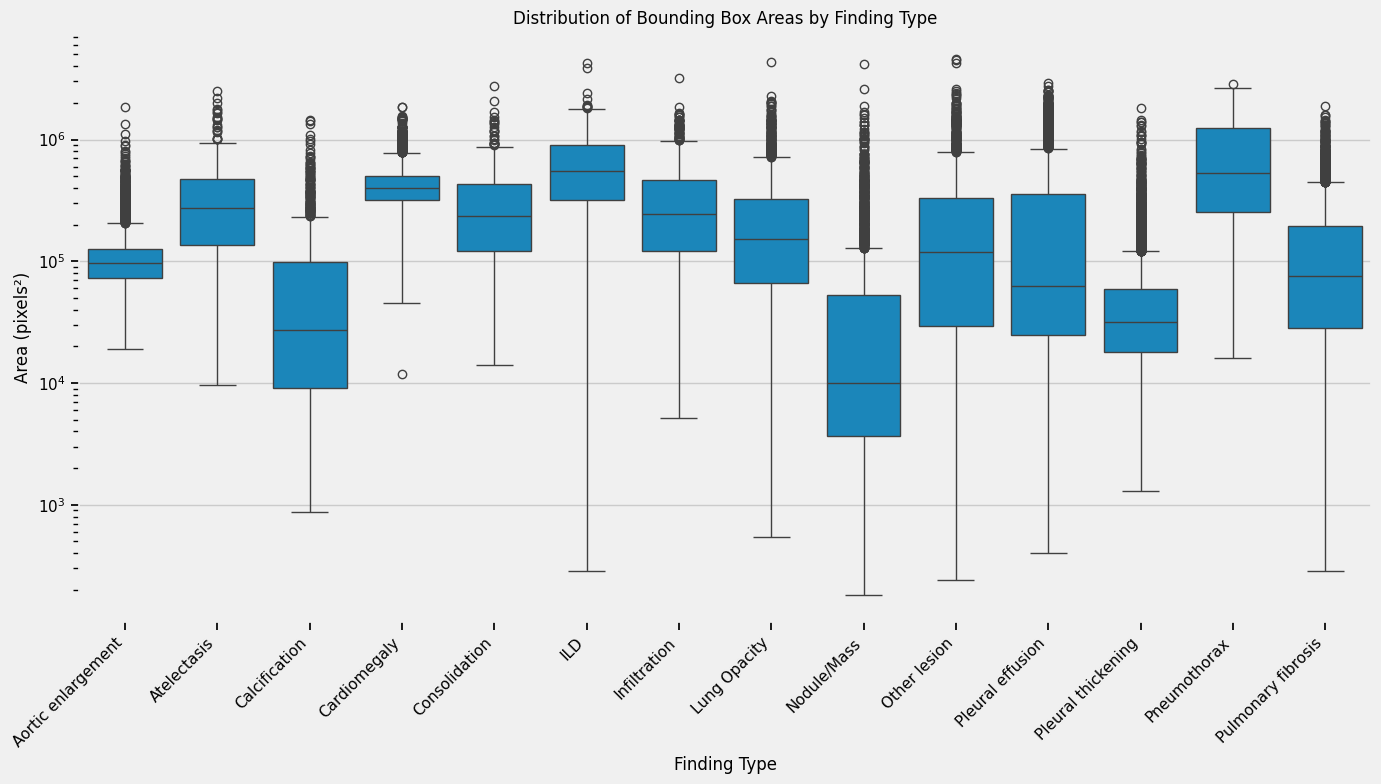

In [8]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='class_id', y='area', data=finding_df)
plt.xticks(range(14), [class_names[i] for i in range(14)], rotation=45, ha='right')
plt.title('Distribution of Bounding Box Areas by Finding Type')
plt.ylabel('Area (pixels²)')
plt.xlabel('Finding Type')
plt.yscale('log') 
plt.tight_layout()
plt.show()

### Bounding Box Size Analysis

Findings show considerable size variation (10³ to 10⁶ pixels²) with distinct patterns - Pneumothorax presents largest areas while Nodule/Mass findings are smallest. Implementation needs:
- Multi-scale detection capabilities
- Optimized anchor boxes
- Finding-specific augmentation strategies

### Spatial Distribution 

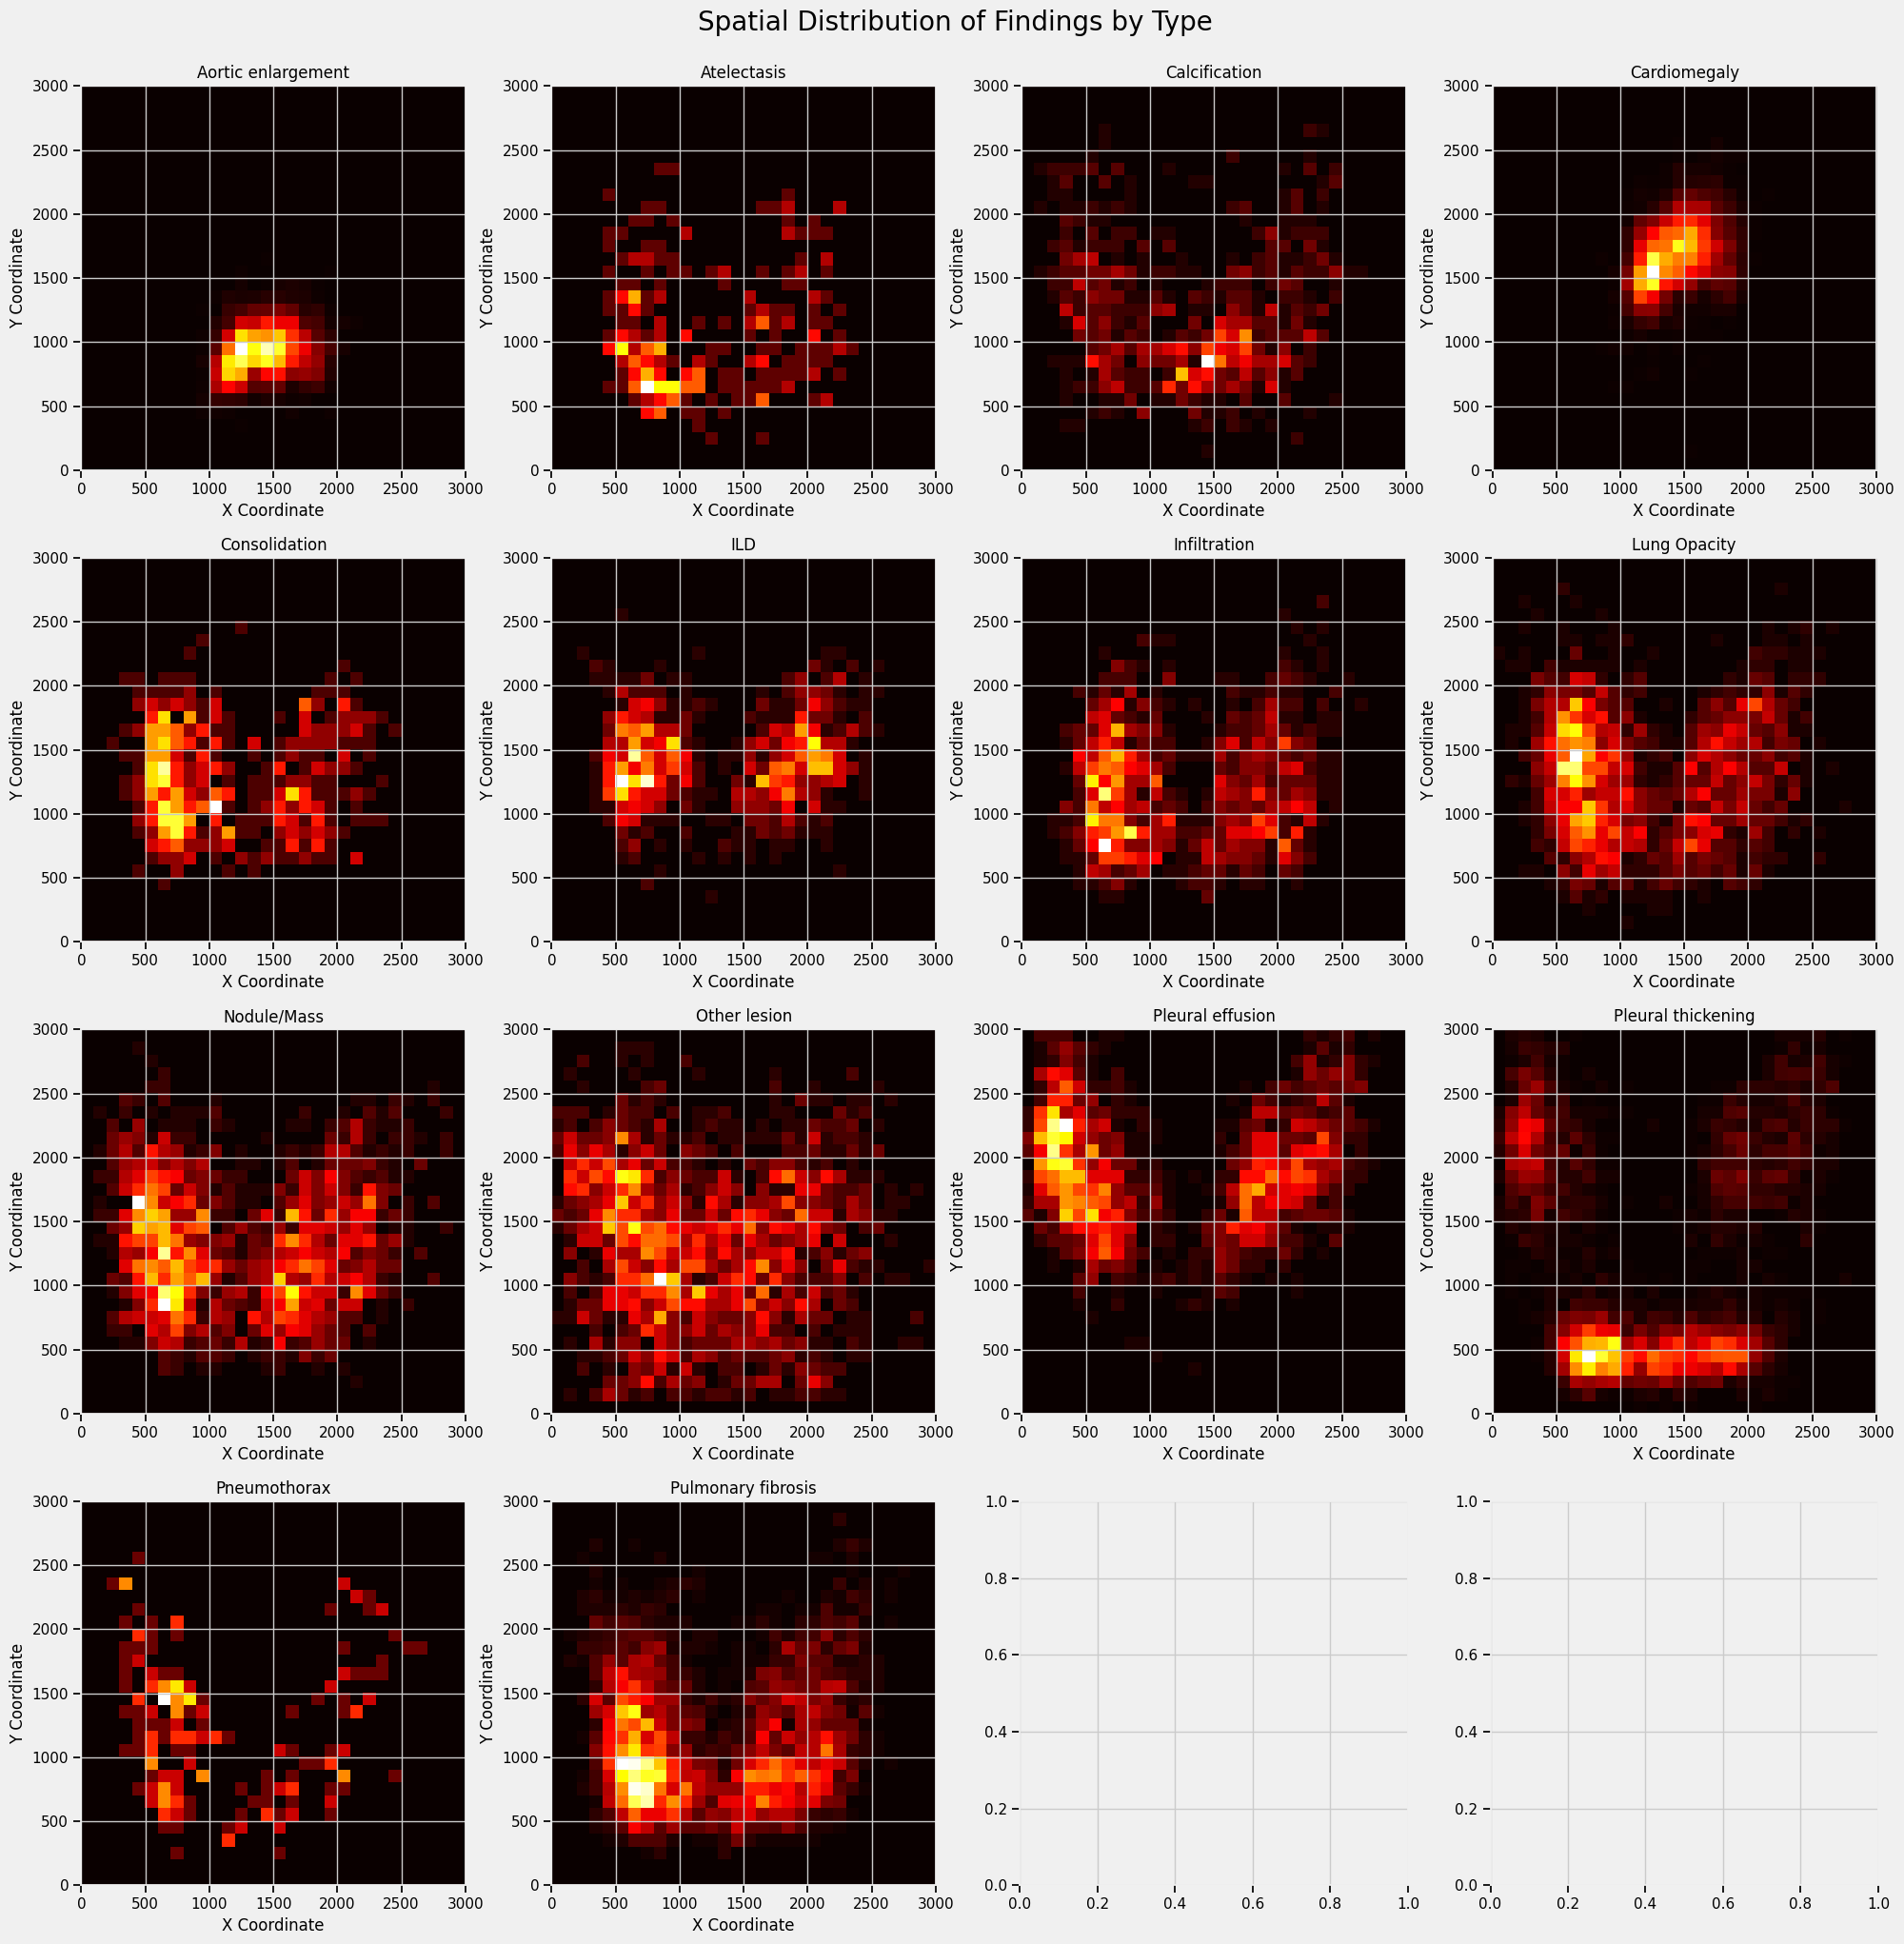

In [9]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
axs = axs.flatten()

for i, class_id in enumerate(range(14)):
    class_data = finding_df[finding_df['class_id'] == class_id]
    if len(class_data) > 0:
        x = (class_data['x_min'] + class_data['x_max']) / 2
        y = (class_data['y_min'] + class_data['y_max']) / 2
        
        heatmap, xedges, yedges = np.histogram2d(x, y, bins=30, range=[[0, 3000], [0, 3000]])
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        
        axs[i].imshow(heatmap.T, extent=extent, origin='lower', cmap='hot', interpolation='nearest')
        axs[i].set_title(class_names[class_id])
        axs[i].set_xlabel('X Coordinate')
        axs[i].set_ylabel('Y Coordinate')
        
    elif i < 14:  
        axs[i].set_title(f"{class_names[class_id]} (No Data)")
        
    if i >= 14:
        fig.delaxes(axs[i])

plt.tight_layout()
plt.suptitle('Spatial Distribution of Findings by Type', fontsize=20, y=1.02)
plt.show()

### Spatial Distribution 

The heatmap visualization reveals distinct anatomical patterns that align with clinical knowledge:

- **Aortic enlargement**: Concentrated in the upper central chest, corresponding to the aortic arch location
- **Cardiomegaly**: Focused in the middle left hemithorax, representing the cardiac silhouette 
- **Pleural thickening**: Concentrated along the lateral and basal aspects of the lung fields
- **Pleural effusion**: Localized to the lateral and lower lung zones, where fluid typically accumulates
- **Lung Opacity** and **Consolidation**: Dispersed throughout the lung fields with bilateral distribution
- **Pneumothorax**: Shows distinctive peripheral pattern along the lateral aspects of the lung

These spatial patterns provide valuable insights for model development:
- Anatomical location is a strong feature for differentiating between findings
- Some conditions have highly predictable locations while others are more diffuse
- The model should leverage spatial context while maintaining flexibility for atypical presentations

## Image Visualization

Let's examine some actual X-ray images with their corresponding annotations to understand how findings appear visually and verify the bounding box annotations.

### Image Visualization Function

Creating a function to display X-ray images with their corresponding bounding box annotations.

In [10]:
train_images_path = data_path / 'train_images'

def visualize_image_with_annotations(image_id, df):
    image_path = os.path.join(train_images_path, f"{image_id}.dicom")
    
    if not os.path.exists(image_path):
        print(f"Image {image_id}.dicom not found. Please download it to {train_images_path}")
        return

    
    dicom = pydicom.dcmread(image_path)

    image = dicom.pixel_array.astype(float)
    image = (image - image.min()) / (image.max() - image.min()) * 255.0
    image = image.astype(np.uint8)

    plt.figure(figsize=(8, 6))

    plt.imshow(image, cmap='gray')

    image_annotations = df[df['image_id'] == image_id]
    
    # Add bounding boxes and labels
    for _, annotation in image_annotations.iterrows():
        x_min, y_min = annotation['x_min'], annotation['y_min']
        x_max, y_max = annotation['x_max'], annotation['y_max']
        class_id = annotation['class_id']

        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                            fill=False, edgecolor='red', linewidth=1.5)  
        plt.gca().add_patch(rect)
  
        plt.text(x_min, y_min - 5, class_names[class_id], 
                color='white', fontsize=9, backgroundcolor='red')
    
    plt.title(f"Image ID: {image_id}", fontsize=10)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

### Available Images Analysis

Checking which images are available in our dataset and which findings they contain.

In [11]:
def analyze_available_images():
    available_images = [f[:-6] for f in os.listdir(train_images_path) 
                      if f.endswith('.dicom')]
    
    if not available_images:
        print("No images found in the directory. Please download some sample images.")
        return []
    
    print(f"Found {len(available_images)} images in {train_images_path}")
    
    findings_df = finding_df[finding_df['image_id'].isin(available_images)]
    
    if findings_df.empty:
        print("No annotations found for the available images.")
        return available_images
    
    class_counts = findings_df['class_id'].value_counts().sort_index()
    
    print("\nFindings in available images:")
    for class_id, count in class_counts.items():
        print(f"- {class_names[class_id]}: {count} instances")
    
    available_classes = set(class_counts.index)
    missing_classes = set(range(14)) - available_classes
    
    if missing_classes:
        print("\nMissing findings in available images:")
        for c in missing_classes:
            print(f"- {class_names[c]}")
    
    return available_images

### Sample Image Visualization

Let's visualize a few sample images with their annotations to understand the data.

Found 500 images in ..\data\raw\train_images

Findings in available images:
- Aortic enlargement: 625 instances
- Atelectasis: 102 instances
- Calcification: 196 instances
- Cardiomegaly: 435 instances
- Consolidation: 172 instances
- ILD: 212 instances
- Infiltration: 264 instances
- Lung Opacity: 464 instances
- Nodule/Mass: 387 instances
- Other lesion: 437 instances
- Pleural effusion: 462 instances
- Pleural thickening: 753 instances
- Pneumothorax: 112 instances
- Pulmonary fibrosis: 759 instances

Randomly selected 3 images for visualization

Visualizing image: 8f175ebdd1fb0e26809311ca829077b8
Findings: ['Pleural thickening', 'Pulmonary fibrosis', 'Aortic enlargement', 'Infiltration', 'Lung Opacity']


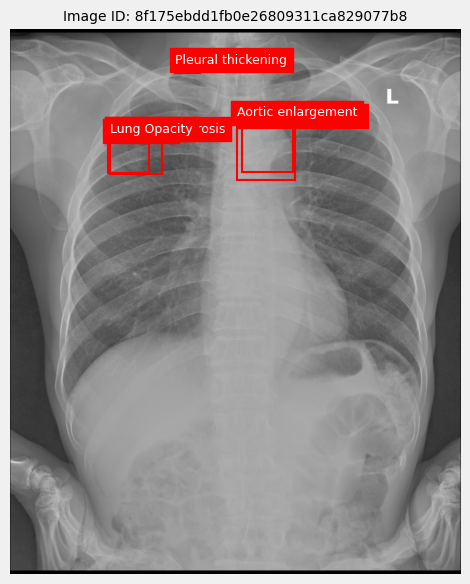


Visualizing image: bdd7f0b920e6c5ea82526986ffb63001
Findings: ['Pleural thickening', 'Pulmonary fibrosis', 'Pleural effusion', 'Aortic enlargement', 'Other lesion']


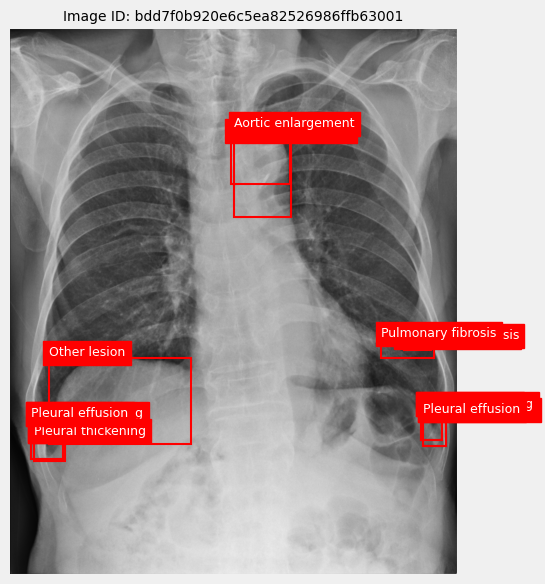


Visualizing image: 1c1a57cb8b3893348ecfb6e704a1b87e
Findings: ['Infiltration', 'Lung Opacity']


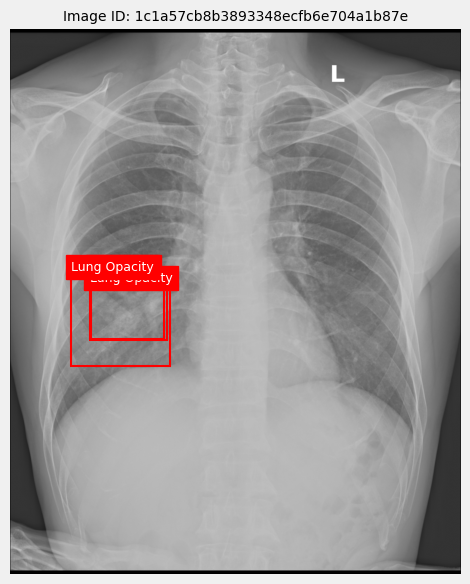

In [12]:
available_images = analyze_available_images()

if available_images:
    num_samples = min(3, len(available_images))
    samples = random.sample(available_images, num_samples)
    
    print(f"\nRandomly selected {num_samples} images for visualization")
    
    for img_id in samples:
        print(f"\nVisualizing image: {img_id}")
        image_findings = finding_df[finding_df['image_id'] == img_id]['class_id'].unique()
        print(f"Findings: {[class_names[c] for c in image_findings]}")
        visualize_image_with_annotations(img_id, finding_df)
else:
    print("No images available for visualization.")

## YOLO Format Conversion

YOLOv8 requires a specific format for annotations:
- One text file per image with the same name as the image
- Each line in the text file representing one object: `class_id center_x center_y width height`
- All values normalized to the range [0, 1]
- Class IDs starting from 0

Let's create a function to convert our VinBigData annotations to YOLO format.

In [13]:
def convert_to_yolo_format(img_id, annotations_df, output_dir, img_width=None, img_height=None):
    """
    Convert bounding box annotations to YOLO format for a single image
    """
    img_annotations = annotations_df[annotations_df['image_id'] == img_id]
    
    if img_annotations.empty:
        return
    
    # If dimensions not provided, read from DICOM
    if img_width is None or img_height is None:
        dicom_path = os.path.join(train_images_path, f"{img_id}.dicom")
        if not os.path.exists(dicom_path):
            print(f"Error: Image {img_id}.dicom not found")
            return
            
        try:
            dicom = pydicom.dcmread(dicom_path)
            img_height, img_width = dicom.pixel_array.shape
        except Exception as e:
            print(f"Error reading DICOM dimensions: {e}")
            return
    
    os.makedirs(output_dir, exist_ok=True)

    output_file = os.path.join(output_dir, f"{img_id}.txt")
    
    with open(output_file, 'w') as f:
        for _, row in img_annotations.iterrows():
            x_min, y_min = row['x_min'], row['y_min']
            x_max, y_max = row['x_max'], row['y_max']
            class_id = row['class_id']
            
            # YOLO format requires normalized center coordinates and dimensions
            x_center = ((x_min + x_max) / 2) / img_width
            y_center = ((y_min + y_max) / 2) / img_height
            width = (x_max - x_min) / img_width
            height = (y_max - y_min) / img_height
            
            # Ensure values are in range [0, 1]
            x_center = max(0, min(x_center, 1))
            y_center = max(0, min(y_center, 1))
            width = max(0, min(width, 1))
            height = max(0, min(height, 1))
            
            
            f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

## Creating Dataset Structure for YOLO

YOLOv8 expects a specific directory structure for training. Let's set up train and validation splits.

In [14]:
def prepare_yolo_dataset(df, images, output_base_dir, train_ratio=0.8):
    """
    Prepare YOLO dataset structure with train/val splits
    """
    
    # Create directories
    train_dir = os.path.join(output_base_dir, 'train')
    val_dir = os.path.join(output_base_dir, 'val')
    train_labels_dir = os.path.join(train_dir, 'labels')
    val_labels_dir = os.path.join(val_dir, 'labels')
    train_images_dir = os.path.join(train_dir, 'images')
    val_images_dir = os.path.join(val_dir, 'images')
    
    os.makedirs(train_labels_dir, exist_ok=True)
    os.makedirs(val_labels_dir, exist_ok=True)
    os.makedirs(train_images_dir, exist_ok=True)
    os.makedirs(val_images_dir, exist_ok=True)
    
    # Shuffle and split images into train and validation sets
    images_copy = images.copy()
    random.shuffle(images_copy)
    split_idx = int(len(images_copy) * train_ratio)
    train_images = images_copy[:split_idx]
    val_images = images_copy[split_idx:]
    
    print(f"Processing {len(train_images)} training images and {len(val_images)} validation images")
    
    # Convert annotations to YOLO format
    for img_id in train_images:
        convert_to_yolo_format(img_id, df, train_labels_dir)
        
    for img_id in val_images:
        convert_to_yolo_format(img_id, df, val_labels_dir)
    
    # Create data.yaml configuration file
    data_yaml = {
        'train': './train/images',
        'val': './val/images',
        'nc': 14,  
        'names': [class_names[i] for i in range(14)] 
    }
    
    with open(os.path.join(output_base_dir, 'data.yaml'), 'w') as f:
        yaml.dump(data_yaml, f, default_flow_style=False)
    
    print(f"Created YOLO dataset structure in {output_base_dir}")
    print(f"Created data.yaml with class information")
    
    return train_images, val_images

## Converting DICOM to PNG for YOLO

YOLOv8 works best with standard image formats like PNG. Let's convert our DICOM files to PNG.

In [15]:
def convert_dicom_to_png(img_id, src_dir, dest_dir):
    dicom_path = os.path.join(src_dir, f"{img_id}.dicom")
    png_path = os.path.join(dest_dir, f"{img_id}.png")
    
    try:
        dicom = pydicom.dcmread(dicom_path)
        
        # Convert to float and normalize to 0-255
        image = dicom.pixel_array.astype(float)
        image = (image - image.min()) / (image.max() - image.min()) * 255.0
        image = image.astype(np.uint8)
        
        cv2.imwrite(png_path, image)
        return True
    except Exception as e:
        print(f"Error converting {img_id}: {e}")
        return False

In [16]:
project_root = Path('../')
processed_data_dir = os.path.join(project_root, 'data', 'processed', 'yolo_dataset')
print("Preparing YOLO dataset...")

train_images, val_images = prepare_yolo_dataset(finding_df, available_images, processed_data_dir)
print("\nConverting DICOM images to PNG format...")

total_images = len(train_images) + len(val_images)
converted_count = 0

train_images_dir = os.path.join(processed_data_dir, 'train', 'images')
for img_id in train_images:
    if convert_dicom_to_png(img_id, train_images_path, train_images_dir):
        converted_count += 1
    if converted_count % 50 == 0:
        print(f"Converted {converted_count}/{total_images} images...")

val_images_dir = os.path.join(processed_data_dir, 'val', 'images')
for img_id in val_images:
    if convert_dicom_to_png(img_id, train_images_path, val_images_dir):
        converted_count += 1
    if converted_count % 50 == 0:
        print(f"Converted {converted_count}/{total_images} images...")

print(f"\nConverted {converted_count}/{total_images} images successfully!")
print("\nDataset preparation complete! The data is now ready for YOLOv8 training.")

Preparing YOLO dataset...
Processing 400 training images and 100 validation images
Created YOLO dataset structure in ..\data\processed\yolo_dataset
Created data.yaml with class information

Converting DICOM images to PNG format...
Converted 50/500 images...
Converted 100/500 images...
Converted 150/500 images...
Converted 200/500 images...
Converted 250/500 images...
Converted 300/500 images...
Converted 350/500 images...
Converted 400/500 images...
Converted 450/500 images...
Converted 500/500 images...

Converted 500/500 images successfully!

Dataset preparation complete! The data is now ready for YOLOv8 training.


## Sample Verification of YOLO Format

Let's verify a few samples to ensure our conversion was successful.


Verifying sample: f244d8f6b541d370470f56b8f6ebcb3b
Files exist. Displaying image with YOLO annotations...


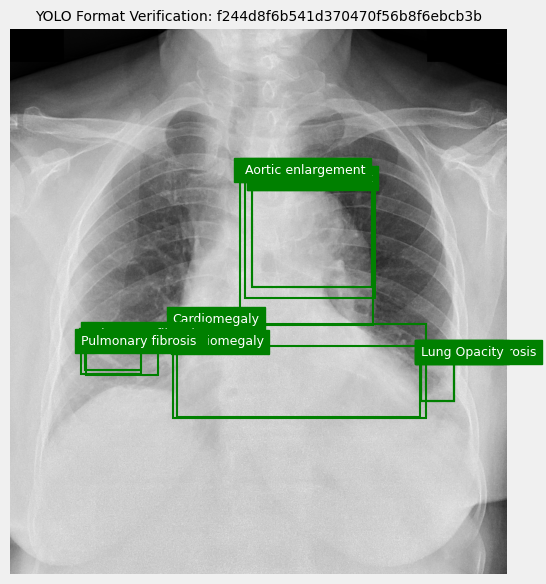

YOLO annotation content (12 objects):
  Object 1: Class Cardiomegaly, center=(0.582530, 0.626967), size=(0.509639, 0.172338)
  Object 2: Class Other lesion, center=(0.861847, 0.641603), size=(0.067470, 0.080864)
  Object 3: Class Aortic enlargement, center=(0.597189, 0.403769), size=(0.269076, 0.276253)
  Object 4: Class Pulmonary fibrosis, center=(0.206627, 0.601720), size=(0.112851, 0.046469)
  Object 5: Class Pulmonary fibrosis, center=(0.861847, 0.641603), size=(0.067470, 0.080864)
  Object 6: Class Cardiomegaly, center=(0.580924, 0.647091), size=(0.489558, 0.129894)
  Object 7: Class Lung Opacity, center=(0.861847, 0.641603), size=(0.067470, 0.080864)
  Object 8: Class Aortic enlargement, center=(0.609237, 0.377790), size=(0.242570, 0.191365)
  Object 9: Class Pulmonary fibrosis, center=(0.225703, 0.600988), size=(0.143775, 0.066228)
  Object 10: Class Other lesion, center=(0.609237, 0.377790), size=(0.242570, 0.191365)
  Object 11: Class Pulmonary fibrosis, center=(0.203815, 0.60

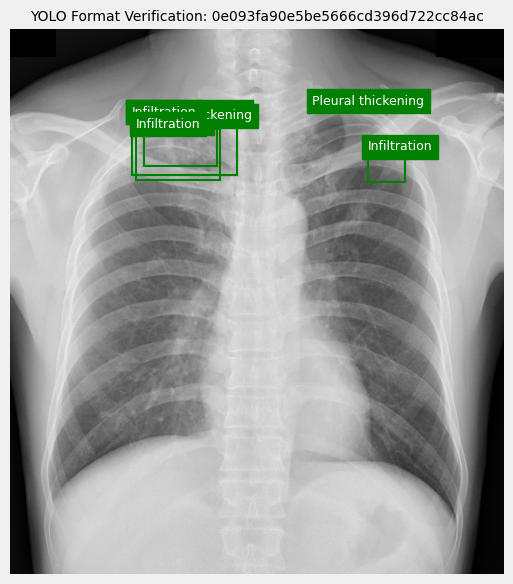

YOLO annotation content (7 objects):
  Object 1: Class Pulmonary fibrosis, center=(0.353377, 0.213885), size=(0.211923, 0.108268)
  Object 2: Class Infiltration, center=(0.345968, 0.216069), size=(0.146795, 0.070827)
  Object 3: Class Pleural thickening, center=(0.329428, 0.181435), size=(0.129566, 0.028393)
  Object 4: Class Pleural thickening, center=(0.629566, 0.145710), size=(0.033770, 0.012480)
  Object 5: Class Infiltration, center=(0.763267, 0.251794), size=(0.075810, 0.057410)
  Object 6: Class Infiltration, center=(0.353377, 0.213885), size=(0.211923, 0.108268)
  Object 7: Class Infiltration, center=(0.340283, 0.229485), size=(0.170572, 0.093292)


In [17]:
def verify_yolo_conversion(sample_count=3):
    """
    Verify a few random samples to ensure YOLO conversion was successful
    """

    samples = random.sample(train_images, min(sample_count, len(train_images)))
    
    for img_id in samples:
        print(f"\nVerifying sample: {img_id}")
        png_path = os.path.join(processed_data_dir, 'train', 'images', f"{img_id}.png")
        anno_path = os.path.join(processed_data_dir, 'train', 'labels', f"{img_id}.txt")
        
        if not os.path.exists(png_path):
            print(f"Error: PNG image not found at {png_path}")
            continue
            
        if not os.path.exists(anno_path):
            print(f"Error: YOLO annotation not found at {anno_path}")
            continue
            
        print("Files exist. Displaying image with YOLO annotations...")

        image = cv2.imread(png_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        height, width = image.shape[:2]

        with open(anno_path, 'r') as f:
            lines = f.readlines()

        plt.figure(figsize=(8, 6))
        plt.imshow(image, cmap='gray')

        for line in lines:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center = float(parts[1]) * width
            y_center = float(parts[2]) * height
            bbox_width = float(parts[3]) * width
            bbox_height = float(parts[4]) * height
            
            # Convert center coordinates to top-left and bottom-right
            x_min = int(x_center - (bbox_width / 2))
            y_min = int(y_center - (bbox_height / 2))
            x_max = int(x_center + (bbox_width / 2))
            y_max = int(y_center + (bbox_height / 2))
            

            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                fill=False, edgecolor='green', linewidth=1.5)
            plt.gca().add_patch(rect)
            

            plt.text(x_min, y_min - 5, class_names[class_id], 
                    color='white', fontsize=9, backgroundcolor='green')
        
        plt.title(f"YOLO Format Verification: {img_id}", fontsize=10)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        

        print(f"YOLO annotation content ({len(lines)} objects):")
        for i, line in enumerate(lines):
            parts = line.strip().split()
            print(f"  Object {i+1}: Class {class_names[int(parts[0])]}, "
                  f"center=({parts[1]}, {parts[2]}), size=({parts[3]}, {parts[4]})")


verify_yolo_conversion(sample_count=2)

## Test Set Processing

This test set processing was added separately when we reached Notebook 04 for clinical validation. While processed independently, it follows the exact same preprocessing pipeline as the training and validation data to ensure consistency and reliability in our clinical evaluation.

The test set maintains the same DICOM to PNG conversion, YOLO format annotation conversion, and quality verification procedures used for the training data.

Processing test dataset...
Found 100 test images in ..\data\raw\test_images

Findings in test images:
- Aortic enlargement: 120 instances
- Atelectasis: 14 instances
- Calcification: 21 instances
- Cardiomegaly: 88 instances
- Consolidation: 31 instances
- ILD: 53 instances
- Infiltration: 42 instances
- Lung Opacity: 100 instances
- Nodule/Mass: 80 instances
- Other lesion: 68 instances
- Pleural effusion: 98 instances
- Pleural thickening: 144 instances
- Pneumothorax: 20 instances
- Pulmonary fibrosis: 147 instances

Processing 100 test images
Updated data.yaml with test set path

Converting test DICOM images to PNG format...
Converted 20/100 test images...
Converted 40/100 test images...
Converted 60/100 test images...
Converted 80/100 test images...
Converted 100/100 test images...

Test conversion complete: 100/100 images converted
Test dataset preparation complete! Ready for clinical validation.

Verifying test sample: 4d911f55a3576833aa411f5718c8021e
Test files exist. Displayin

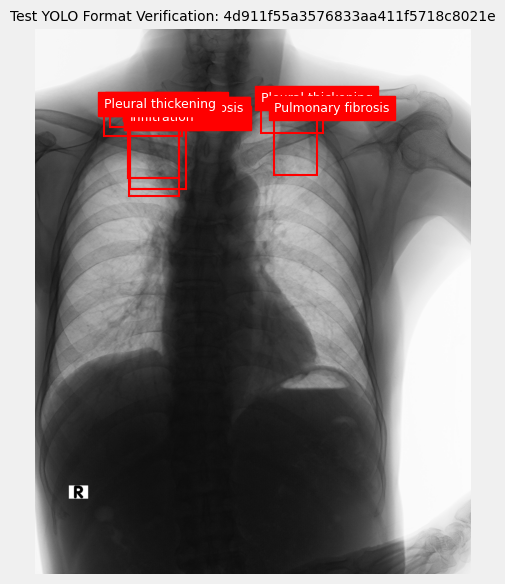

Test YOLO annotation content (9 objects):
  Object 1: Class Pulmonary fibrosis, center=(0.282335, 0.231771), size=(0.129774, 0.122569)
  Object 2: Class Pleural thickening, center=(0.589627, 0.162500), size=(0.143663, 0.056250)
  Object 3: Class Atelectasis, center=(0.272352, 0.213542), size=(0.115885, 0.120139)
  Object 4: Class Pulmonary fibrosis, center=(0.273872, 0.230208), size=(0.114583, 0.150694)
  Object 5: Class Pulmonary fibrosis, center=(0.597873, 0.210243), size=(0.097656, 0.114236)
  Object 6: Class Pleural thickening, center=(0.252387, 0.161979), size=(0.158420, 0.034375)
  Object 7: Class Pulmonary fibrosis, center=(0.272352, 0.213542), size=(0.115885, 0.120139)
  Object 8: Class Infiltration, center=(0.282335, 0.231771), size=(0.129774, 0.122569)
  Object 9: Class Pleural thickening, center=(0.247179, 0.171007), size=(0.179253, 0.051042)

Verifying test sample: 7d0e636b3ef2ccbb0c67b3243a1478ce
Test files exist. Displaying image with YOLO annotations...


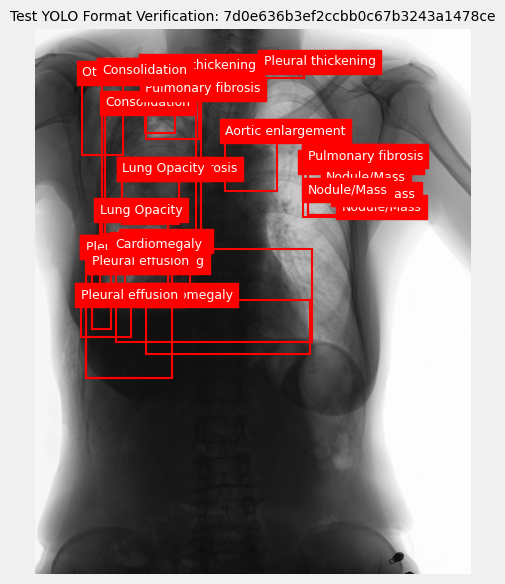

Test YOLO annotation content (28 objects):
  Object 1: Class Lung Opacity, center=(0.316189, 0.149132), size=(0.121962, 0.103819)
  Object 2: Class Lung Opacity, center=(0.281684, 0.434201), size=(0.149306, 0.076042)
  Object 3: Class Pleural thickening, center=(0.329427, 0.101042), size=(0.156250, 0.052778)
  Object 4: Class Pulmonary fibrosis, center=(0.265191, 0.311111), size=(0.130208, 0.094444)
  Object 5: Class Atelectasis, center=(0.216146, 0.524132), size=(0.198785, 0.232986)
  Object 6: Class Nodule/Mass, center=(0.673177, 0.291146), size=(0.094618, 0.100347)
  Object 7: Class Consolidation, center=(0.265625, 0.259375), size=(0.208333, 0.232639)
  Object 8: Class Nodule/Mass, center=(0.710503, 0.339062), size=(0.011285, 0.009375)
  Object 9: Class Pleural thickening, center=(0.153429, 0.493229), size=(0.042969, 0.115625)
  Object 10: Class Nodule/Mass, center=(0.652561, 0.254514), size=(0.015191, 0.009722)
  Object 11: Class Pleural thickening, center=(0.571398, 0.078472), siz

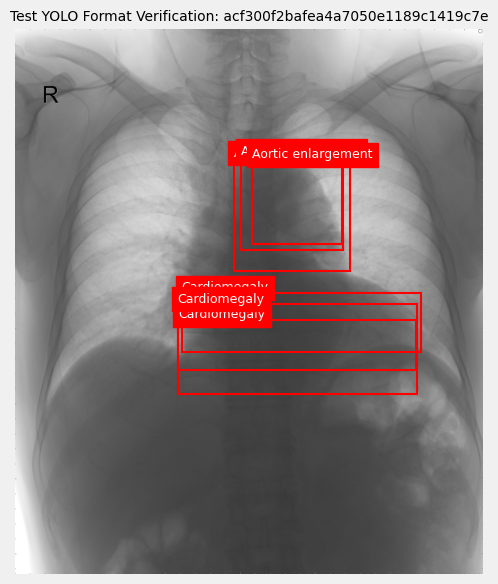

Test YOLO annotation content (6 objects):
  Object 1: Class Aortic enlargement, center=(0.591189, 0.339569), size=(0.248975, 0.207306)
  Object 2: Class Aortic enlargement, center=(0.591445, 0.318662), size=(0.216701, 0.173415)
  Object 3: Class Aortic enlargement, center=(0.602203, 0.316241), size=(0.192111, 0.154489)
  Object 4: Class Cardiomegaly, center=(0.602459, 0.579225), size=(0.509221, 0.092430)
  Object 5: Class Cardiomegaly, center=(0.611168, 0.538292), size=(0.512295, 0.109155)
  Object 6: Class Cardiomegaly, center=(0.603227, 0.586708), size=(0.511783, 0.164613)

Verifying test sample: 92c7afb7f1496f6f676fc6f079337fc8
Test files exist. Displaying image with YOLO annotations...


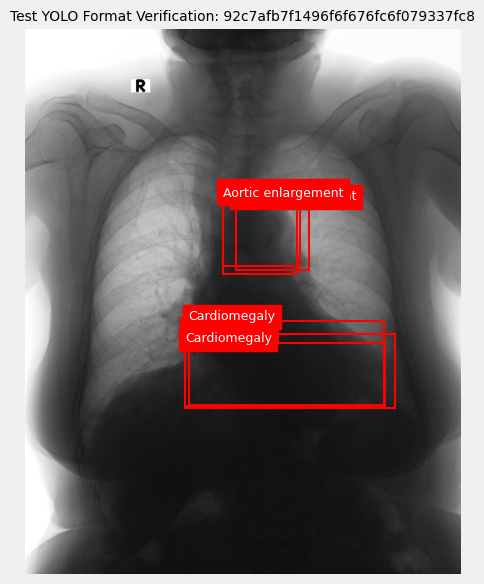

Test YOLO annotation content (6 objects):
  Object 1: Class Cardiomegaly, center=(0.609809, 0.627604), size=(0.480903, 0.137153)
  Object 2: Class Cardiomegaly, center=(0.597656, 0.633854), size=(0.459201, 0.114236)
  Object 3: Class Cardiomegaly, center=(0.600911, 0.612847), size=(0.449219, 0.152778)
  Object 4: Class Aortic enlargement, center=(0.543620, 0.369618), size=(0.179253, 0.128819)
  Object 5: Class Aortic enlargement, center=(0.568793, 0.378472), size=(0.167101, 0.125694)
  Object 6: Class Aortic enlargement, center=(0.540365, 0.379340), size=(0.170139, 0.139236)


In [18]:
def analyze_test_images():
    """
    Analyze available test images following the same pattern as training data
    """
    test_images_path = os.path.join(project_root, 'data', 'raw', 'test_images')
    
    if not os.path.exists(test_images_path):
        print("Test images directory not found. Please ensure test images are properly organized.")
        return []
    
    # Get available test images (DICOM files)
    available_test_images = [f[:-6] for f in os.listdir(test_images_path) 
                            if f.endswith('.dicom')]
    
    if not available_test_images:
        print("No test images found in the directory.")
        return []
    
    print(f"Found {len(available_test_images)} test images in {test_images_path}")
    
    # Analyze findings in test images
    test_findings_df = finding_df[finding_df['image_id'].isin(available_test_images)]
    
    if test_findings_df.empty:
        print("No annotations found for the available test images.")
        return available_test_images
    
    class_counts = test_findings_df['class_id'].value_counts().sort_index()
    
    print("\nFindings in test images:")
    for class_id, count in class_counts.items():
        print(f"- {class_names[class_id]}: {count} instances")
    
    available_classes = set(class_counts.index)
    missing_classes = set(range(14)) - available_classes
    
    if missing_classes:
        print("\nMissing findings in test images:")
        for c in missing_classes:
            print(f"- {class_names[c]}")
    
    return available_test_images

def convert_test_to_yolo_format(img_id, annotations_df, output_dir):
    """
    Convert test image annotations to YOLO format using the same logic as training
    """
    img_annotations = annotations_df[annotations_df['image_id'] == img_id]
    
    if img_annotations.empty:
        return
    
    # Read DICOM dimensions from raw test images
    test_images_path = os.path.join(project_root, 'data', 'raw', 'test_images')
    dicom_path = os.path.join(test_images_path, f"{img_id}.dicom")
    
    if not os.path.exists(dicom_path):
        print(f"Error: Test image {img_id}.dicom not found")
        return
        
    try:
        dicom = pydicom.dcmread(dicom_path)
        img_height, img_width = dicom.pixel_array.shape
    except Exception as e:
        print(f"Error reading test DICOM dimensions: {e}")
        return
    
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, f"{img_id}.txt")
    
    with open(output_file, 'w') as f:
        for _, row in img_annotations.iterrows():
            x_min, y_min = row['x_min'], row['y_min']
            x_max, y_max = row['x_max'], row['y_max']
            class_id = row['class_id']
            
            # YOLO format requires normalized center coordinates and dimensions
            x_center = ((x_min + x_max) / 2) / img_width
            y_center = ((y_min + y_max) / 2) / img_height
            width = (x_max - x_min) / img_width
            height = (y_max - y_min) / img_height
            
            # Ensure values are in range [0, 1]
            x_center = max(0, min(x_center, 1))
            y_center = max(0, min(y_center, 1))
            width = max(0, min(width, 1))
            height = max(0, min(height, 1))
            
            f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

def prepare_test_dataset():
    """
    Process test dataset following the same pipeline as training data
    """
    test_base_dir = os.path.join(processed_data_dir, 'test')
    test_images_dir = os.path.join(test_base_dir, 'images')
    test_labels_dir = os.path.join(test_base_dir, 'labels')
    
    # Create directories
    os.makedirs(test_images_dir, exist_ok=True)
    os.makedirs(test_labels_dir, exist_ok=True)
    
    # Analyze test images
    test_images = analyze_test_images()
    
    if not test_images:
        print("No test images to process.")
        return []
    
    print(f"\nProcessing {len(test_images)} test images")
    
    # Convert annotations to YOLO format
    for img_id in test_images:
        convert_test_to_yolo_format(img_id, finding_df, test_labels_dir)
    
    # Update data.yaml to include test path
    data_yaml_path = os.path.join(processed_data_dir, 'data.yaml')
    if os.path.exists(data_yaml_path):
        with open(data_yaml_path, 'r') as f:
            data_config = yaml.safe_load(f)
        
        # Add test path
        data_config['test'] = './test/images'
        
        with open(data_yaml_path, 'w') as f:
            yaml.dump(data_config, f, default_flow_style=False)
        
        print("Updated data.yaml with test set path")
    
    return test_images

def verify_test_yolo_conversion(test_images, sample_count=2):
    """
    Verify test YOLO conversion following the same pattern as training verification
    """
    if not test_images:
        print("No test images to verify.")
        return
    
    samples = random.sample(test_images, min(sample_count, len(test_images)))
    
    for img_id in samples:
        print(f"\nVerifying test sample: {img_id}")
        
        png_path = os.path.join(processed_data_dir, 'test', 'images', f"{img_id}.png")
        anno_path = os.path.join(processed_data_dir, 'test', 'labels', f"{img_id}.txt")
        
        if not os.path.exists(png_path):
            print(f"Error: Test PNG image not found at {png_path}")
            continue
            
        if not os.path.exists(anno_path):
            print(f"Error: Test YOLO annotation not found at {anno_path}")
            continue
            
        print("Test files exist. Displaying image with YOLO annotations...")
        
        image = cv2.imread(png_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        height, width = image.shape[:2]
        
        with open(anno_path, 'r') as f:
            lines = f.readlines()
        
        plt.figure(figsize=(8, 6))
        plt.imshow(image, cmap='gray')
        
        for line in lines:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center = float(parts[1]) * width
            y_center = float(parts[2]) * height
            bbox_width = float(parts[3]) * width
            bbox_height = float(parts[4]) * height
            
            x_min = int(x_center - (bbox_width / 2))
            y_min = int(y_center - (bbox_height / 2))
            x_max = int(x_center + (bbox_width / 2))
            y_max = int(y_center + (bbox_height / 2))
            
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                fill=False, edgecolor='red', linewidth=1.5)
            plt.gca().add_patch(rect)
            
            plt.text(x_min, y_min - 5, class_names[class_id], 
                    color='white', fontsize=9, backgroundcolor='red')
        
        plt.title(f"Test YOLO Format Verification: {img_id}", fontsize=10)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        print(f"Test YOLO annotation content ({len(lines)} objects):")
        for i, line in enumerate(lines):
            parts = line.strip().split()
            print(f"  Object {i+1}: Class {class_names[int(parts[0])]}, "
                  f"center=({parts[1]}, {parts[2]}), size=({parts[3]}, {parts[4]})")

# Execute test set processing
print("Processing test dataset...")
test_images = prepare_test_dataset()

# Convert DICOM to PNG for test images (following same pattern as train/val)
if test_images:
    print("\nConverting test DICOM images to PNG format...")
    test_raw_path = os.path.join(project_root, 'data', 'raw', 'test_images')
    test_processed_path = os.path.join(processed_data_dir, 'test', 'images')
    
    converted_count = 0
    for img_id in test_images:
        if convert_dicom_to_png(img_id, test_raw_path, test_processed_path):
            converted_count += 1
        
        if converted_count % 20 == 0 and converted_count > 0:
            print(f"Converted {converted_count}/{len(test_images)} test images...")
    
    print(f"\nTest conversion complete: {converted_count}/{len(test_images)} images converted")
    print("Test dataset preparation complete! Ready for clinical validation.")
    
    # Verify test conversion
    verify_test_yolo_conversion(test_images, sample_count=2)
else:
    print("No test images processed.")

# Execute test set processing
print("Processing test dataset...")
test_images = prepare_test_dataset()

# Convert DICOM to PNG for test images (following same pattern as train/val)
if test_images:
    print("\nConverting test DICOM images to PNG format...")
    test_raw_path = os.path.join(project_root, 'data', 'raw', 'test_images')
    test_processed_path = os.path.join(processed_data_dir, 'test', 'images')
    
    converted_count = 0
    for img_id in test_images:
        if convert_dicom_to_png(img_id, test_raw_path, test_processed_path):
            converted_count += 1
        
        if converted_count % 20 == 0 and converted_count > 0:
            print(f"Converted {converted_count}/{len(test_images)} test images...")
    
    print(f"\nTest conversion complete: {converted_count}/{len(test_images)} images converted")
    print("Test dataset preparation complete! Ready for clinical validation.")
    
    # Verify test conversion
    verify_test_yolo_conversion(test_images, sample_count=2)
else:
    print("No test images processed.")

## Summary

In this notebook, we have:

1. Explored the VinBigData Chest X-ray dataset
2. Analyzed the distribution of different medical findings
3. Visualized sample X-ray images with their bounding box annotations
4. Converted the dataset to YOLO format for training:
   - Split data into training and validation sets
   - Converted annotations to YOLO format
   - Converted DICOM images to PNG format
   - Created the necessary directory structure
   - Generated the data.yaml configuration file
5. Processed independent test set for clinical validation.
6. Generated complete dataset configuration.

The data is now ready for training a YOLOv8 model in the next notebook.